<a href="https://colab.research.google.com/github/kikiru328/Bone_Detection/blob/main/%EC%8A%B9%ED%98%9C/img_preprocessing_def.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import 

import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import glob
import math

# contrast 함수 version1,2

In [178]:
# contrast 함수 1
def contrast(img, mask, ksize):
    # # Morphlogy - Tophat

    # ksize = int(img.mean() * 0.5)
    k = cv2.getStructuringElement(cv2.MORPH_CROSS, (ksize, ksize))
    img = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, k)

    # contrast
    low = int(img.mean())*1.3
    high = low + 100
    height, width = img.shape
    
    img = img.astype("float")
    img_ = (255 / (high - low)) * (img-low)
    img_ = ((img_>0)*img_)
    img_ = ((img_-255)>0)*255+img_*(img_<255)
    img_ = img_.astype("uint8")  
    # 마스크 씌우기
    img = cv2.bitwise_and(img_, mask)

    return img


  # alpha = 1.49
  # img = np.clip((1+alpha)*img - 128*alpha, 0, 255).astype(np.uint8)


# contrast 함수 2
def contrast_roi(img, low, high):
    h, w = img.shape
    img_ = np.zeros(img.shape, dtype=np.uint8)
    for y in range(h):
        for x in range(w):
            temp = int((255 / (high - low)) * (img[y][x] - low))
            if temp > 255:
                img_[y][x] = 255
            elif temp < 0:
                img_[y][x] = 0
            else:
                img_[y][x] = temp
    return img_

# merong1 함수 (전처리- 이상함 좀)

In [183]:
# 이미지 1개 img 적용
img = cv2.imread('1_F.jpg',cv2.IMREAD_COLOR)

mask


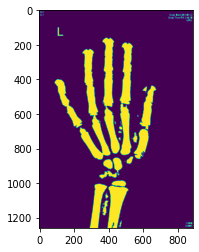

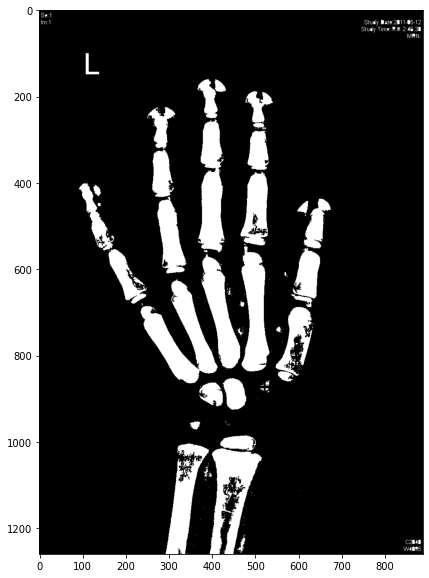

In [182]:

# 이미지 전처리 함수 (img, 모폴로지값1, 2,3)
def merong(img,a,b,c):
  # 이미지 가져오기
  # img = cv2.imread('1_F_손목 - 복사본.jpg',cv2.IMREAD_COLOR)
  img_ = img.copy()

  # 이미지 Lab
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)

  # 모폴리지
  k = cv2.getStructuringElement(cv2.MORPH_CROSS, (a, a))
  img = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, k)

  # 필터
  img = cv2.bilateralFilter(img,-1, 10, 5)

  # Lab to gray for binary
  img = cv2.cvtColor(img, cv2.COLOR_Lab2BGR)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # # 정규화
  # img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

  # # 평탄화 (Clahe)
  # # img = cv2.equalizeHist(img)
  # clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(3,3)) #CLAHE 생성
  # img= clahe.apply(img)           #CLAHE 적용


  # binary
  ret, mask = cv2.threshold(img, 
                          np.mean(img), # thresh= 이미지의 평균값을 임계치로
                          255,
                          cv2.THRESH_BINARY)
  
  # 같은 픽셀 강도를 갖는 애들 연결해줌 (오브젝트 검출)
  contours, hierarchy = cv2.findContours(mask, # 마스크에서
                                         cv2.RETR_EXTERNAL, # 바깥쪽 라인만
                                         cv2.CHAIN_APPROX_SIMPLE) # 컨투어 꼭짓점 좌표만 제공 
  # 그려주기
  cv2.drawContours(mask, contours,
                   -1, (255, 255, 255), -1) # -1: 모든 컨트어 표시 /color/ fill

  print('mask')
  plt.imshow(mask)
  plt.show()

  #### 강 조
  # 모폴로지
  k = cv2.getStructuringElement(cv2.MORPH_CROSS, (b, b))
  img = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, k)

  # contrast
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    
  # # 뼈강조하고 마스크랑 비트 연산
  # # 모폴로지
  # k2 = cv2.getStructuringElement(cv2.MORPH_CROSS, (c, c))
  # img = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, k2)

  # contrast 함수 넣어주기 
  img= contrast(img,mask,c)



  # 컨투어
  contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cv2.drawContours(img, contours, -1, (255, 255, 255), -1)

  # 마스크랑 비트 연산 - 이미지랑 마스크 둘 다에서 흰색인 부분만 출력
  img = cv2.bitwise_and(img, mask) 

  # 크기 표준화
  # img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
  img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

  plt.figure(figsize=(12,10))
  plt.imshow(img,'gray')
  plt.show()

merong(img,55,30,50)


# merong2 함수 (좀 고침)

In [ ]:
# 이미지 1개 img 적용
img = cv2.imread('1_F.jpg',cv2.IMREAD_COLOR)

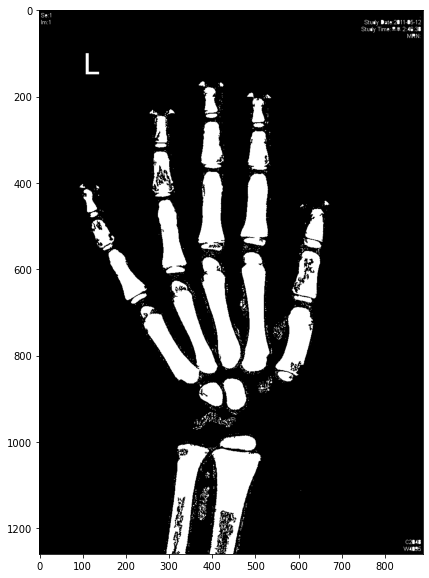

In [200]:
## 메롱두번쨰 
# 이미지 전처리 함수 (img, 모폴로지값1, 2,3)
def merong(img,a,b,d,e):
  # 이미지 가져오기
  # img = cv2.imread('1_F_손목 - 복사본.jpg',cv2.IMREAD_COLOR)
  img1 = img.copy()

  # 이미지 Lab
  img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
  img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2Lab)

  # 모폴리지
  k = cv2.getStructuringElement(cv2.MORPH_CROSS, (a, a))
  img1 = cv2.morphologyEx(img1, cv2.MORPH_TOPHAT, k) # 밝기 값이 크게 튀는 곳을 강조

  # 필터
  img1 = cv2.bilateralFilter(img1,-1, d, e)

  # Lab to gray for binary
  img1 = cv2.cvtColor(img1, cv2.COLOR_Lab2BGR)
  img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

  # # 정규화
  # img1 = cv2.normalize(img1, None, 0, 255, cv2.NORM_MINMAX)

  # # 평탄화 (Clahe)
  # # img = cv2.equalizeHist(img)
  # clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(3,3)) #CLAHE 생성
  # img1= clahe.apply(img1)           #CLAHE 적용


  # binary
  ret, mask = cv2.threshold(img1,
                            np.mean(img1), # thresh= 이미지의 평균값을 임계치로
                            255,
                            cv2.THRESH_BINARY) # ret - 임계값, mask = img마스크
  
  # 같은 픽셀 강도를 갖는 애들 연결해줌 (오브젝트 검출)
  contours, hierarchy = cv2.findContours(mask, # 마스크에서
                                         cv2.RETR_EXTERNAL, # 바깥쪽 라인만
                                         cv2.CHAIN_APPROX_SIMPLE) # 컨투어 꼭짓점 좌표만 제공 

  cv2.drawContours(mask, contours, -1, (255,255,255), -1) # -1: 모든 컨트어 표시 /color/ fill


  # plt.imshow(mask)
  # plt.show()










  #### 강 조
  img2 = img.copy()
  # 모폴로지
  k2 = cv2.getStructuringElement(cv2.MORPH_CROSS,(b,b))
  img2 = cv2.morphologyEx(img2, cv2.MORPH_TOPHAT, k2)

  # contrast
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
  # img2= contrast(img2,mask,c)
  if img2.mean() <= 15:
      low = img2.mean() * 2.3
      high = img2.mean() * 2.5
  elif img2.mean() <= 20:
      low = img2.mean() * 2.3
      high = img2.mean() * 2.8
  else:
      low = img2.mean() * 2.3
      high = img2.mean() * 3

  img2 = contrast_roi(img2, low, high)


    
  # # 뼈강조하고 마스크랑 비트 연산
  # # 모폴로지
  # k2 = cv2.getStructuringElement(cv2.MORPH_CROSS, (c, c))
  # img = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, k2)


  # 컨투어
  contours, hierarchy = cv2.findContours(img2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cv2.drawContours(img2, contours, -1, (255, 255, 255), -1)

  # 마스크랑 비트 연산 - 이미지랑 마스크 둘 다에서 흰색인 부분만 출력
  img2 = cv2.bitwise_and(img2, mask) 
  # img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
  img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

  plt.figure(figsize=(12,10))
  plt.imshow(img2,'gray')
  plt.show()

merong(img,55,25,25,10)

# 함수 이미지path로 적용시켜보기 
- 이렇게까지 했는데도 살이 그대로 남아있는 이유는?

['8_F.jpg', '9_F.jpg', '6_F.jpg', '7_F.jpg', '5_F.jpg', '1_F.jpg', '4_F.jpg', '20_F.jpg', '16_F.jpg', '19_F.jpg', '17_F.jpg', '15_F.jpg', '12_F.jpg', '3_F.jpg', '13_F.jpg', '14_F.jpg', '11_F.jpg', '18_F.jpg', '2_F.jpg', '10_F.jpg', 'Bone age 3yr F.xlsx', 'BA_F_3yr.zip']


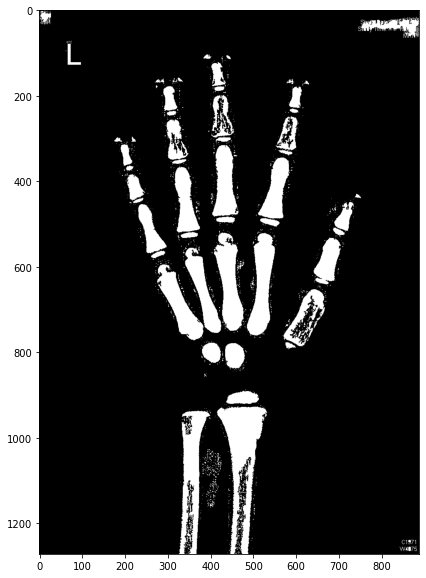

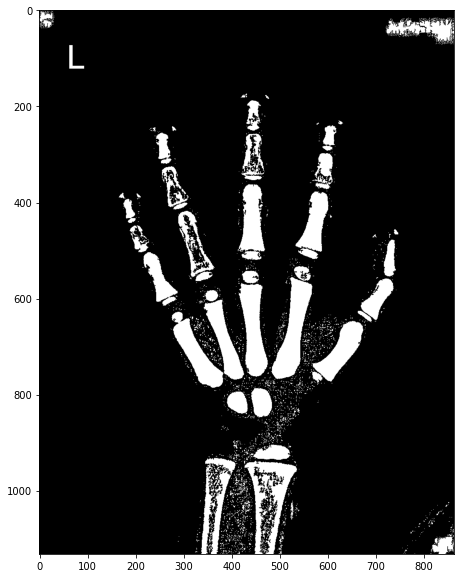

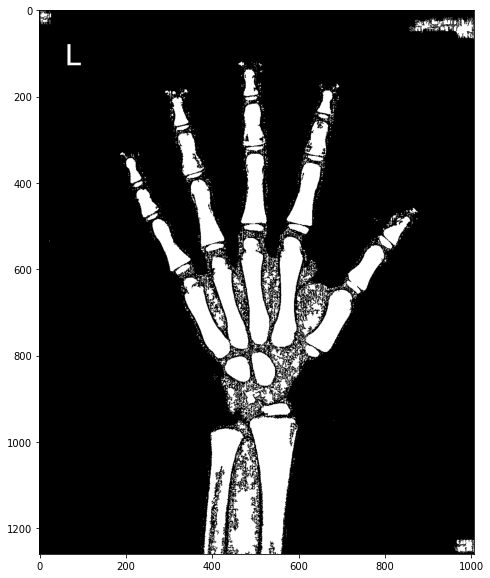

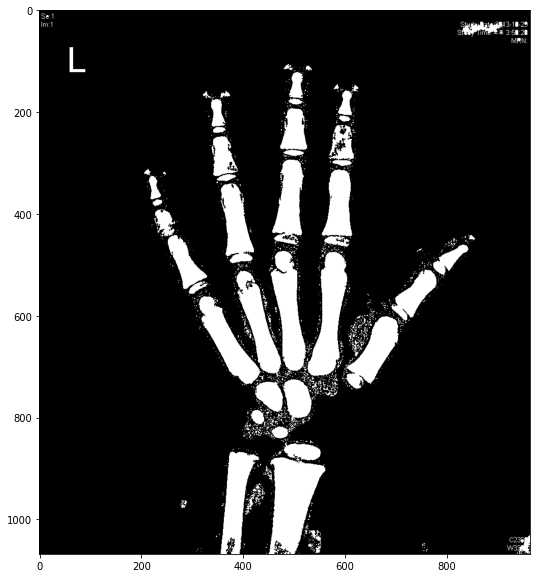

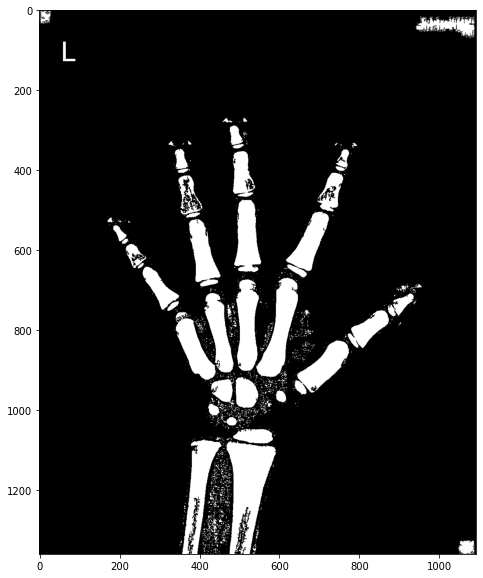

In [195]:
# 이미지 여러개에 함수 적용
import os
path = '/content/drive/MyDrive/cakd_colab/2차플젝/데이터 원본/데이터 원본/first'
dir_list = os.listdir(path)
print(dir_list)

for item in dir_list[:5] :
  img = cv2.imread(path+'/'+f'{item}',cv2.IMREAD_COLOR)
  merong(img,55,25,25,10)

In [5]:
# 이미지 1개 가져오기
from google.colab import files
uploaded = files.upload()

Saving 1_F.jpg to 1_F.jpg


In [199]:
# 이미지 1개 img 적용
img = cv2.imread('1_F.jpg',cv2.IMREAD_COLOR)
